# Introduction

Common Vulnerabilities and Exposures (CVE) is a dictionary of publicly known information security vulnerabilities and exposures run by the MITRE Corporation. [U.S. National Vulnerability Database (NVD)](https://nvd.nist.gov) is integrated this source of information in their feed with some added metrics. One can download the JSON file used in this analysis [here](https://nvd.nist.gov/feeds/json/cve/1.0/nvdcve-1.0-2018.json.zip). This file contains information about publicly known information from security vulnerabilities in software and hardware along with their corresponding exposures.

Let's first start with the exploration of data fields in JSON file. 

**Abbreviations used in the notebook**:
- CVE - Common Vulnerabilities and Exposures
- NVD - National Vulnerability Database
- CVSS - Common Vulnerability Scoring System
- CWE - Common Weakness Enumeration

**Base JSON fields used for analysis**:
- ID: unique CVE identifier 
- description: text information with problem details and the affected system versions listed
- publishedDate: the date when first occurence of CVE was documented
- lastModifiedDate: the date when some changes on CVE report was made (Note: I read that this information can be updated on a bunch of CVE entries even if the fields' changes were made only for some of them. It is not a good information for a problem I will solve in a second part of this notebook)
- cvssV2_baseScore: is used to calculate the severity of vulnerability and ranges from 0 to 10 with 10 being the highest vulnerability risk
- cvssV2_exploitabilityScore: this metric measures the current state of exploit techniques or code availability. Public availability of easy-to-use exploit code increases the number of potential attackers by including those who are unskilled, thereby increasing the severity of the vulnerability ([source](https://www.first.org/cvss/v2/guide)).
- cvssV2_impactScore: is composed of the three impact metrics which measure how a vulnerability, if exploited, will directly affect an IT asset, where the impacts are independently defined as the degree of loss of confidentiality, integrity, and availability ([source](https://www.first.org/cvss/v2/guide)).
- reference_cnt: the number of references for a given CVE
- exploit_db_flag: 1 if the cve has at least one reference to www.exploit-db.com, 0 otherwise

**Additional JSON fields used for current analysis**:
- cwe: a software weakness, ie error that can lead to a vulnerability
- version_cnt: the number of system/OS versions affected by a given CVE


One should be aware that the Base Score is just a linear combination of Exploitability and Impact scores when building a model. Below are formulas for calculating Base, Exploitability and Impact scores according to NVD website:

BaseScore = (.6*Impact +.4*Exploitability-1.5)*f(Impact)
 
Impact = 10.41 * (1 - (1 - ConfImpact) * (1 - IntegImpact) * (1 - AvailImpact))

Exploitability = 20 * AccessComplexity * Authentication * AccessVector

f(Impact) = 0 if Impact=0; 1.176 otherwise


**Note**: The term "system" will be used as a generalized reference to all sofware and hardware products that can potentially become vulnerable to hacker attack and are mentioned on the NVD site.

# Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`, `seaborn`.

In [455]:
import pandas as pd
import numpy as np
import datetime

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import requests, zipfile, io

gc.enable()
%matplotlib inline

sns.set_palette("muted")

# Read in Data

In [458]:
r = requests.get('https://nvd.nist.gov/feeds/json/cve/1.0/nvdcve-1.0-2018.json.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [459]:
df = pd.read_json('nvdcve-1.0-2018.json')
df = pd.DataFrame([item for item in df['CVE_Items']])

# some CVEs are duplicates of other ones with empty fields in them, so we filter them out
def filter_fn(row):
    if 'baseMetricV2' not in row['impact'].keys(): return False
    else: return True

m = df.apply(filter_fn, axis=1)
df = df[m]

After deleting incorrect 106 CVEs, a total of 14097 CVEs are left. 

In [406]:
def get_id(row):
    return row['cve']['CVE_data_meta']['ID']

def get_base_score(row):
    return row['impact']['baseMetricV2']['cvssV2']['baseScore']

def get_expl_score(row):
    return row['impact']['baseMetricV2']['exploitabilityScore']

def get_impact_score(row):
    return row['impact']['baseMetricV2']['impactScore']

def get_descr(row):
    return row['cve']['description']['description_data'][0]['value']

def get_number_refs(row):
    return len(row['cve']['references']['reference_data'])

def get_db_flag(row):
    for el in row['cve']['references']['reference_data']:
        if 'www.exploit-db.com' in el['url']:
            return 1
    return 0

def convert_published_date(row):
    d = datetime.datetime.strptime(row['publishedDate'],"%Y-%m-%dT%H:%MZ")
    new_format = "%Y-%m-%d"
#     new_format = "%d/%m/%Y"
    return d.strftime(new_format)

def convert_modified_date(row):
    d = datetime.datetime.strptime(row['lastModifiedDate'],"%Y-%m-%dT%H:%MZ")
    new_format = "%Y-%m-%d"
    return d.strftime(new_format)

def get_num_versions(row):
    if row['cve']['affects']['vendor']['vendor_data']:
        return len(row['cve']['affects']['vendor']['vendor_data'][0]['product']['product_data'][0]['version']['version_data'])
    else:
        return 0

def get_cwe_score(row):
    return row['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']

def get_sevLevel(row):
    return row['impact']['baseMetricV2']['severity']

df = df.copy()
df['ID'] = df.apply(get_id, axis=1)
df['description'] = df.apply(get_descr, axis=1)
df['cvssV2_baseScore'] = df.apply(get_base_score, axis=1)
df['cvssV2_exploitabilityScore'] = df.apply(get_expl_score, axis=1)
df['cvssV2_impactScore'] = df.apply(get_impact_score, axis=1)
df['reference_cnt'] = df.apply(get_number_refs, axis=1)
df['exploit_db_flag'] = df.apply(get_db_flag, axis=1)
df['publishedDate'] = df.apply(convert_published_date, axis=1)
df['lastModifiedDate'] = df.apply(convert_modified_date, axis=1)

# Additional features
df['cwe'] = df.apply(get_cwe_score, axis=1)
df['version_cnt'] = df.apply(get_num_versions, axis=1)
df['sevLevel'] = df.apply(get_sevLevel, axis=1)

In [407]:
cve_data = df[['ID', 'description', 'publishedDate', 'lastModifiedDate', 'cvssV2_baseScore', 'cvssV2_exploitabilityScore', 'cvssV2_impactScore', 'reference_cnt', 'exploit_db_flag', 'version_cnt', 'cwe', 'sevLevel']]
cve_data.reset_index(inplace=True, drop=True)

del df
gc.collect()

cve_data.head(10)

,ID,description,publishedDate,lastModifiedDate,cvssV2_baseScore,cvssV2_exploitabilityScore,cvssV2_impactScore,reference_cnt,exploit_db_flag,version_cnt,cwe,sevLevel
0,CVE-2018-0001,"A remote, unauthenticated attacker may be able...",2018-01-10,2018-02-23,7.5,10.0,6.4,3,0,9,CWE-416,HIGH
1,CVE-2018-0002,On SRX Series and MX Series devices with a Ser...,2018-01-10,2018-02-15,4.3,8.6,2.9,2,0,9,CWE-399,MEDIUM
2,CVE-2018-0003,A specially crafted MPLS packet received or pr...,2018-01-10,2018-10-25,6.1,6.5,6.9,3,0,15,CWE-399,MEDIUM
3,CVE-2018-0004,A sustained sequence of different types of nor...,2018-01-10,2018-02-06,7.1,8.6,6.9,2,0,9,CWE-400,HIGH
4,CVE-2018-0005,QFX and EX Series switches configured to drop ...,2018-01-10,2018-02-02,5.8,6.5,6.4,2,0,3,CWE-754,MEDIUM
5,CVE-2018-0006,A high rate of VLAN authentication attempts se...,2018-01-10,2018-02-15,2.9,5.5,2.9,2,0,5,CWE-399,LOW
6,CVE-2018-0007,An unauthenticated network-based attacker able...,2018-01-10,2018-02-02,10.0,10.0,10.0,2,0,13,CWE-94,HIGH
7,CVE-2018-0008,An unauthenticated root login may allow upon r...,2018-01-10,2018-02-06,7.2,3.9,10.0,2,0,9,CWE-284,HIGH
8,CVE-2018-0009,"On Juniper Networks SRX series devices, firewa...",2018-01-10,2018-02-15,4.3,8.6,2.9,3,0,3,CWE-264,MEDIUM
9,CVE-2018-0010,A vulnerability in the Juniper Networks Junos ...,2018-01-10,2018-02-02,4.0,8.0,2.9,1,0,7,CWE-284,MEDIUM


Not all the CVE IDs have information on versions of systems affected. We put zero values for `version_cnt` in this case, however, more detailed analysis on this issue should be performed.

# Exploratory Data Analysis

In [408]:
cve_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14097 entries, 0 to 14096
Data columns (total 12 columns):
ID                            14097 non-null object
description                   14097 non-null object
publishedDate                 14097 non-null object
lastModifiedDate              14097 non-null object
cvssV2_baseScore              14097 non-null float64
cvssV2_exploitabilityScore    14097 non-null float64
cvssV2_impactScore            14097 non-null float64
reference_cnt                 14097 non-null int64
exploit_db_flag               14097 non-null int64
version_cnt                   14097 non-null int64
cwe                           14097 non-null object
sevLevel                      14097 non-null object
dtypes: float64(3), int64(3), object(6)
memory usage: 1.3+ MB


In [409]:
cve_data.describe()

,cvssV2_baseScore,cvssV2_exploitabilityScore,cvssV2_impactScore,reference_cnt,exploit_db_flag,version_cnt
count,14097.000000,14097.000000,14097.000000,14097.000000,14097.000000,14097.000000
mean,5.663006,8.077655,5.135894,2.715259,0.068171,66.234873
std,1.792030,2.005100,2.482626,2.930488,0.252047,440.914681
min,1.200000,1.900000,2.900000,1.000000,0.000000,0.000000
25%,4.300000,8.000000,2.900000,1.000000,0.000000,1.000000
50%,5.000000,8.600000,4.900000,2.000000,0.000000,1.000000
75%,6.800000,10.000000,6.400000,3.000000,0.000000,4.000000
max,10.000000,10.000000,10.000000,137.000000,1.000000,3908.000000


Some CVEs were reported for as much as 3908 versions of different systems! But bear in mind, once some vulnerability was discovered in some system it was usually discovered and reported for many or all previous versions of the similar systems.

## Examine the distribution of parameters

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002952F5B7860>],
      dtype=object)

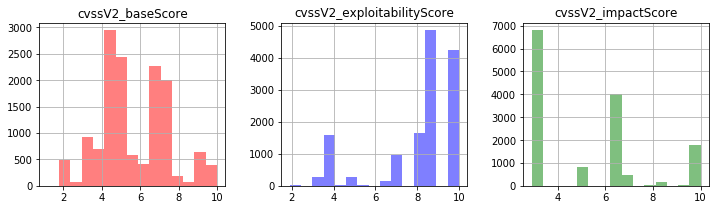

In [410]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))

cve_data.hist('cvssV2_baseScore', bins=15, ax=axes[0], alpha=0.5, color='red')
cve_data.hist('cvssV2_exploitabilityScore', bins=15, ax=axes[1], alpha=0.5, color='blue')
cve_data.hist('cvssV2_impactScore', bins=15, ax=axes[2], alpha=0.5, color='green')

We can see 2 substantial peaks for `cvssV2_baseScore`: around 4-5 points and 7 points, or `MEDIUM` and `HIGH` severity degrees, according to NVD nomenclature.

At the same time, `exploitabilityScore`s are mostly all high. And, almost half of all reported `impactScore`s are lower than 3.

In [411]:
print ("The proportion of CVEs with number of its references greater than 4:", round(cve_data[cve_data['reference_cnt']>4]['ID'].count()/cve_data['ID'].count(), 2))
print ("The proportion of CVEs with number of system versions where this CVE was discovered greater than 19:", round(cve_data[cve_data['version_cnt']>19]['ID'].count()/cve_data['ID'].count(), 2))

The proportion of CVEs with number of its references greater than 4: 0.11
The proportion of CVEs with number of system versions where this CVE was discovered greater than 19: 0.11


## Long editable CVEs - what are they telling us?

Here, I assume that changed `lastModifiedDate` is related to still occurring issues with vulnerability. However, as I understood from the NVD website, this is not necessary could be true. But for simplicity (and because we don't have access to external data sources to know more about the re-occurence of issues in systems), long editable CVE issues are assumed to be not good for system users and vendors. Especially those ones, which have high `baseScore`.

I also make a rough guess that fields with CVEs issues which have been modified for a long period of time and which have been reported on a lot are the worst ones. 

Calculate the months between last modified date and initial CVE report day and plot a histogram.

In [412]:
cve_data['monthsCVE']=  ((pd.to_datetime(cve_data.lastModifiedDate) - pd.to_datetime(cve_data.publishedDate))/np.timedelta64(1, 'M')).astype(int)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029530073BA8>]],
      dtype=object)

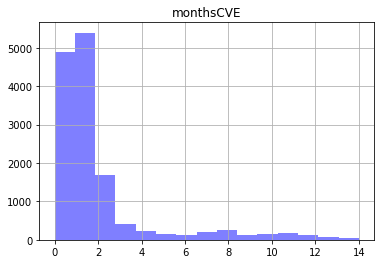

In [413]:
cve_data.hist('monthsCVE', bins=15, alpha=0.5, color='blue')

As it is seen from histogram, most issues are closed within 2-3 months, but some of them were modified in more than 4-6 months. Why is it so? Are these issues not so important or is it particular systems which are more subject to vulnerabilities?
As it is seen from the histogram, most issues are closed within 2-3 months, but some of them were modified in more than 4-6 months. Why is it so? Are these issues not so important or is it particular systems which are more subject to vulnerabilities?

Probably there is some logic in it which cybersecurity professionals can explain but let's try without any side knowledge to figure out how are different continuously reported CVE issues from that which were resolved in a couple of months using data analysis techniques.
Probably there is some logic in it which specialists in cybersecurity can explain but let's try without any side knowledge to figure out how differ are longlasting issues from that resolved in a couple of months using data analysis techniques.

We will assume that issues which have been modified for a period longer than 4 months are continuously-reported issues.

In [414]:
cve_data['longLastingCVE'] = np.where(cve_data.monthsCVE>3, 1, 0)

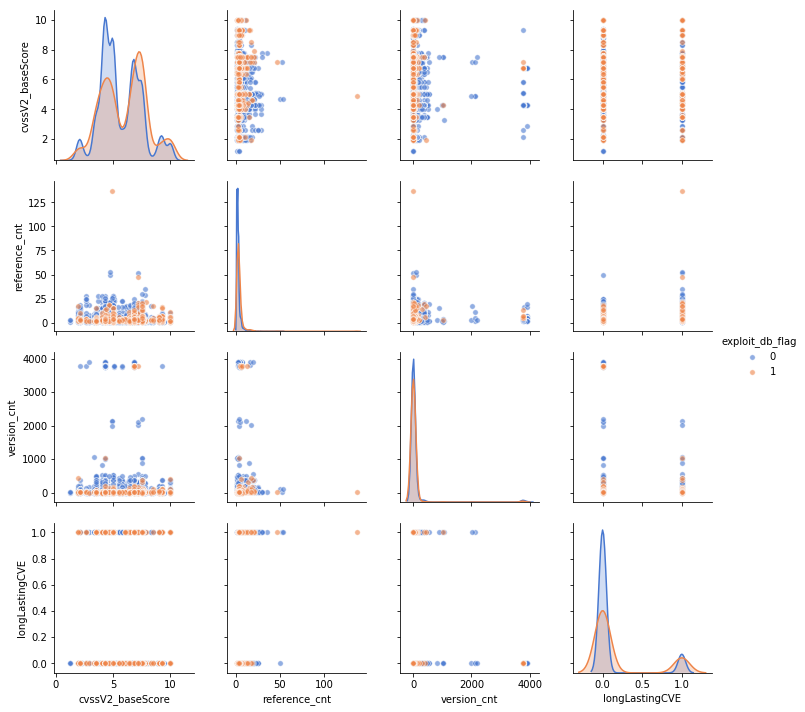

In [415]:
sns.pairplot(cve_data, hue="exploit_db_flag", vars=['cvssV2_baseScore', 'reference_cnt', 'version_cnt', 'longLastingCVE'], plot_kws = {'alpha': 0.6, 's': 30})

These pair plots are ugly but at the same time they provide many insights:
  - CVEs which have a big number of references to different sources (more than 40) are mostly also long-period modified ones;
  - But at the same time, a big number of vulnerable versions of systems is not necessarily associated with a long period of CVE modification;
  - However, in general, a small number of source references goes in couple with a small number of vulnerable system versions for a given CVE;
  - Presence of `exploit_db_flag` means that not so many versions of systems would have vulnerability issues. Probably, it means that the exploit-db community is quite influential to boost the vulnerability issues' resolving process. At the same time, `exploit_db_flag` is not associated with the issue severity, ie. `cvssV2_baseScore`.

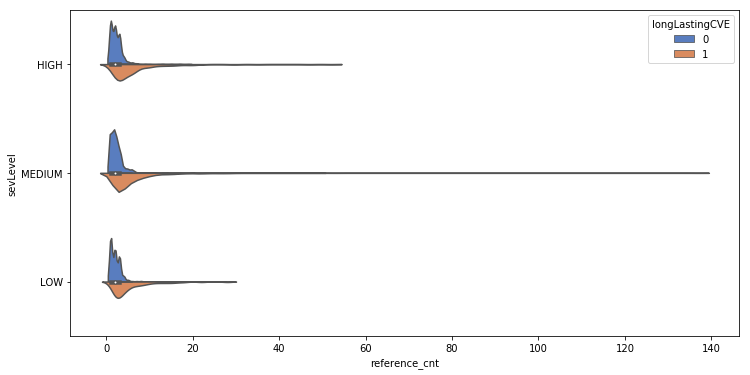

In [416]:
fig, ax = plt.subplots(figsize=(12,6))

sns.violinplot(x="reference_cnt", y="sevLevel", data=cve_data, hue='longLastingCVE', split=True, 
               orient="h", bw=0.2, ax=ax)
plt.show()

The violin plot shows that:
- HIGH and MEDIUM severity level CVEs have a higher number of references and longer report modification periods than the CVEs with LOW severity
- Long report modification period is associated with a bigger number of references
- The extreme number of references is inherent to MEDIUM severity level CVE reports.

These results are in line with the results of pairwise parameter estimation reported above.

# Dig deeper-1: Common Weakness Enumeration (CWE) - what is it?

As it was pointed out in the definition section, in the beginning, CWEs are in some way aggregations of CVEs. For example, while ”Missing Authorization” is a weakness ”Missing Authorization in software X” is a vulnerability. CWE can potentiate the CVE occurrence.

Let's observe the number of unique CWEs in JSON file and plot the histogram of the top most common CWEs.

In [417]:
print ("Number of unique CWEs:", cve_data['cwe'].nunique())

Number of unique CWEs: 102


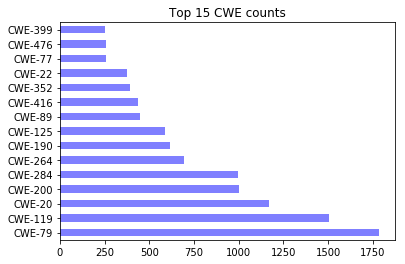

In [418]:
pd.value_counts(cve_data['cwe']).nlargest(15).plot.barh(title='Top 15 CWE counts', alpha=0.5, color='blue')

Just out of curiosity, let's take a look at what most occuring CWEs mean:
- `CWE-79`: Cross-site Scripting
- `CWE-119`: Memory boundary problems
- `CWE-20`: Improper Input Validation
- `CWE-200`: Information Exposure
- `CWE-284`: Improper Access Control


According to [Wikipedia](https://en.wikipedia.org/wiki/Cross-site_scripting), Cross-site Scripting vulnerability is a problem which expanded from JavaScript modes of code injection to the hacker's manipulations using other languages, including ActiveX, Java, VBScript, Flash and HTML. This could explain the big number of reports on this issue (which is probably also increased over time).

### Which CWEs are the most long lasting?

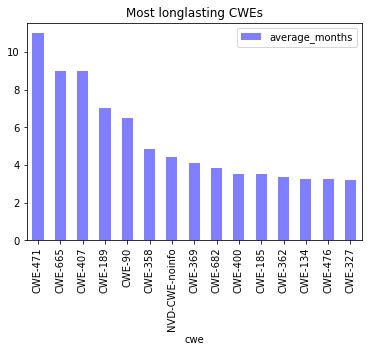

In [419]:
sub = cve_data.groupby('cwe')['monthsCVE'].mean().reset_index(name='average_months')
sub = sub.sort_values(by=['average_months'], ascending=False).head(15)

sub.plot.bar(x='cwe', y='average_months', alpha=0.5, color='blue', title='Most longlasting CWEs') 

Interestingly, the top long lasting CWEs are not the most popular within period of 16 months (January 2018 - April 2019). 

Quick search showed that `CWE-471` -- the most long lasting CWE -- means "Modification of Assumed-Immutable Data (MAID)". The CVEs on this CWE have been modified over an average of 10 months.

### Are there some CWEs which are potentially most harmful?

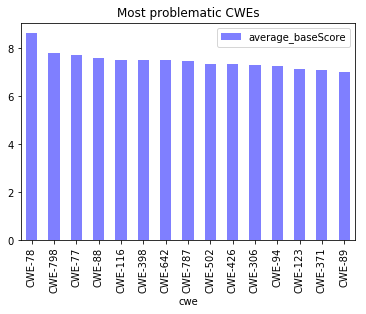

In [420]:
sub2 = cve_data.groupby('cwe')['cvssV2_baseScore'].mean().reset_index(name='average_baseScore')
sub2 = sub2.sort_values(by=['average_baseScore'], ascending=False).head(15)

sub2.plot.bar(x='cwe', y='average_baseScore', alpha=0.5, color='blue', title='Most problematic CWEs') 

Here, nothing especially interesting. However, one CWE is a little outstanding with an average `cvssV2_baseScore` of more than 8.
Again, a quick look at definitions showed that `CWE-78` means "Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')". 
To read more on this issue: https://cwe.mitre.org/data/definitions/78.html.

# Dig deeper-2: product categories

**Note**: the list of products for each category is not comprehensive. With the created dictionary of products for each category we cover only around 50% of all products listed in NVD report. The results of this section should be considered with precaution.

In [421]:
def define_categories(row):
    categories = {'video_players': ['ffmpeg', 'quicktime', 'libav', 'videolan', 'vlc media player', 'qemu'],\
    'http_servers': ['Http Server', 'nginx', 'Http File Server', 'Http Server', 'Lighttpd', 'Monkey Http Daemon'],\
    'encription': ['Encryption', 'OpenSSL' ,'GnuTLS', 'OpenSSH', 'LibreSSL', 'WolfSSL'], \
    'script_lang': ['ruby on rails', 'php', 'asp.net'], \
    'firewalls': ['Firewalls', 'Pfsense' ,'Iptables', 'Ipcop', 'Comodo Internet Security'], \
    'virtualization': ['player', 'docker', 'Hyper-V', 'Vm Virtualbox', 'openvz', 'xen'], \
    'ftp_servers': ['core_FTP', 'ProFTPD', 'Glftpd', 'Pureftpd', 'vsftpd', 'Zftpserver'], \
    'chat_programs': ['kvirc', 'irssi', 'spark', 'Skype'], \
    'sql_servers': ['sql server', 'mysql', 'postgresql'], \
    'os': ['OS', 'ubuntu', 'android', 'linux', 'juniper', 'unix', 'ms-dos', 'mac os']}
    for i, (k, v) in enumerate(categories.items()):
        for el in v:
            if el.lower() in row['description'].lower():
#                 return i
                return k
    return -1

cve_data['pr_category'] = cve_data.apply(define_categories, axis=1)

In [422]:
print ("Amount of CVEs with defined category:", len(cve_data[cve_data['pr_category']!=-1]))

Amount of CVEs with defined category: 7129


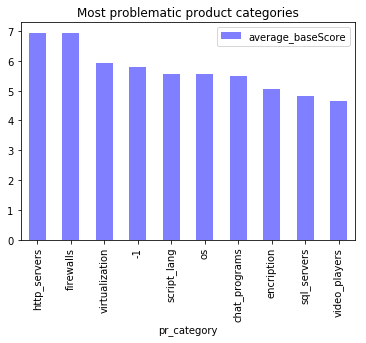

In [423]:
sub2 = cve_data.groupby('pr_category')['cvssV2_baseScore'].mean().reset_index(name='average_baseScore')
sub2 = sub2.sort_values(by=['average_baseScore'], ascending=False).head(15)

sub2.plot.bar(x='pr_category', y='average_baseScore', alpha=0.5, color='blue', title='Most problematic product categories') 

The figure above shows that there is a large difference between the categories, for example, software examined in the `video_players` and `sql_servers` categories have vulnerabilities with an average `cvssV2_baseScore` of around 5 while the `http_servers` and `firewalls` software averaged almost 7. Two theories that could explain this difference are:
1. Software developers for categories like `video_players' or 'sql_servers` have a higher focus on security compared to developers of `http_servers` or `firewalls` software.
2. Video players or SQL servers are running through firewalls and HTTP servers, so the last ones are more predisposed to hacker attacks.
3. We did not split into categories all the data. `-1` categories have a substantial part. Further analysis should be conducted to split into categories more precisely.

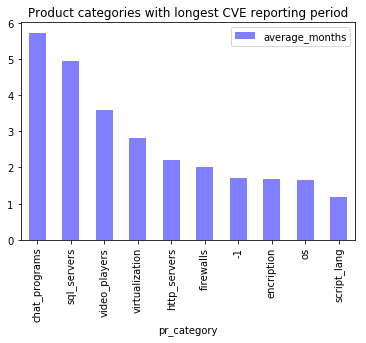

In [424]:
sub = cve_data.groupby('pr_category')['monthsCVE'].mean().reset_index(name='average_months')
sub = sub.sort_values(by=['average_months'], ascending=False).head(15)

sub.plot.bar(x='pr_category', y='average_months', alpha=0.5, color='blue', title='Product categories with longest CVE reporting period') 

`chat_programs` and `sql_servers` are the categories of products with the highest CVE modification period of almost 6 months for `chat_programs` and almost 5 months for `sql_servers`. In contrast `firewalls`, `encryption`, `os` and `script_lang` categories are categories with the smallest reporting periods. Probably, the reason for that is because the last ones are "first-order" systems to be run before doing some operations with programs at the top of the bar plot. So, eliminating vulnerabilities in them is of higher importance.

# Dig deeper-3: experimental part

In our previous analysis we were dealing with descriptive statistics and pairwise feature comparisons. In this part, we will build some predictive model. 

Firstly, we will build a model using a tree-based ML method. Then, we will investigate which features were the most important for our model using SHAP method. Finally, we will give details on model possible improvements. 

But let's first choose and define the target variable.

As I see from the set of parameters we have, there are 2 options:
1. Try to predict `cvssV2_baseScore` score. There is no point to predict it as a continuous number but to split under categories which are defined by NVD (MEDIUM, HIGH, LOW severities) would be reasonable.
2. Build predictive models for `longReported` variable we constructed before. This variable could be a proxy of CVE re-occurrence for some system. However, one should understand that the results of this analysis would not be completely true as this parameter has changed simultaneously with other parameters over time.

In this notebook, I will work on the second problem.

As the first step, let's prepare all our features to feed into the model. We can try to create some additional ones which would probably improve our model quality or we will just filter them out at the feature selection step. But anyway, it is usually a good practice to add a variety of different additional not correlating features to machine learning models when first running.

To make our experiment more able to emit conditions, when we want to predict new vulnerabilities and exposures, we have removed the variables `reference_cnt` and `version_cnt` from the list of features used for the predictive task.

### Imports

In [425]:
import shap, lightgbm
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

In [426]:
def geometric_mean(x):
    return np.exp(np.log(x[x>0]).mean())

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [427]:
def prepare_feats(cve_data):
    refs_per_prCat = cve_data[['reference_cnt', 'pr_category']].groupby('pr_category').median()['reference_cnt']
    cve_data['refs_per_prCat'] = cve_data['pr_category'].map(refs_per_prCat)

    vers_per_prCat = cve_data[['version_cnt', 'pr_category']].groupby('pr_category').median()['version_cnt']
    cve_data['vers_per_prCat'] = cve_data['pr_category'].map(vers_per_prCat)

    refs_per_cwe= cve_data[['reference_cnt', 'cwe']].groupby('cwe').median()['reference_cnt']
    cve_data['refs_per_cwe'] = cve_data['cwe'].map(refs_per_cwe)

    vers_per_cwe = cve_data[['version_cnt', 'cwe']].groupby('cwe').median()['version_cnt']
    cve_data['vers_per_cwe'] = cve_data['cwe'].map(vers_per_cwe)

    refs_per_sevLevel= cve_data[['reference_cnt', 'sevLevel']].groupby('sevLevel').median()['reference_cnt']
    cve_data['refs_per_sevLevel'] = cve_data['sevLevel'].map(refs_per_sevLevel)

    vers_per_sevLevel = cve_data[['version_cnt', 'sevLevel']].groupby('sevLevel').median()['version_cnt']
    cve_data['vers_per_sevLevel'] = cve_data['sevLevel'].map(vers_per_sevLevel)

    refs_per_exploitdb= cve_data[['reference_cnt', 'exploit_db_flag']].groupby('exploit_db_flag').median()['reference_cnt']
    cve_data['refs_per_exploitdb'] = cve_data['exploit_db_flag'].map(refs_per_exploitdb)

    vers_per_exploitdb = cve_data[['version_cnt', 'exploit_db_flag']].groupby('exploit_db_flag').median()['version_cnt']
    cve_data['vers_per_exploitdb'] = cve_data['exploit_db_flag'].map(vers_per_exploitdb)

    # create new features based on 'cvssV2_exploitabilityScore' and 'cvssV2_impactScore' scores.
    cve_data['new_score_product'] = cve_data[['cvssV2_exploitabilityScore', 'cvssV2_impactScore']].prod(axis=1, min_count=1)
    cve_data['new_score_max'] = cve_data[['cvssV2_exploitabilityScore', 'cvssV2_impactScore']].max(axis=1)
    cve_data['new_score_min'] = cve_data[['cvssV2_exploitabilityScore', 'cvssV2_impactScore']].min(axis=1)
    cve_data['new_score_abs_diff'] = cve_data[['cvssV2_exploitabilityScore', 'cvssV2_impactScore']].std(axis=1)
    cve_data['new_score_geom_mean'] = cve_data[['cvssV2_exploitabilityScore', 'cvssV2_impactScore']].apply(geometric_mean, axis=1)
    
    drop_cols = ['ID', 'description', 'publishedDate', 'lastModifiedDate', 'monthsCVE', 'reference_cnt', 'version_cnt' \
                 , 'cvssV2_exploitabilityScore', 'cvssV2_impactScore']
    cve_data = cve_data.drop(drop_cols, axis=1)

    # Categorical features with One-Hot encode
    cve_data, cat_cols = one_hot_encoder(cve_data)
    return cve_data

In [428]:
cve_data = prepare_feats(cve_data)

For our experiments, LightGBM method is decided to use as it usually gives a robust accuracy across different data splits. To provide an explanation on why the prediction was made, the SHAP method is used. It gives better understanding on feature selection process than built-in LightGBM `plot_importance()` method. More information about the SHAP method can be found [here](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27).  

Stratified 5-fold cross validation is used for experiments. Additionally, we left out 20% of data as a test set. Finally, we report mean k-fold AUC score for training set, and macro F-score and plot confusion matrix for left-out test set.

SHAP analysis results are discussed afterwards.

In [449]:
# LightGBM GBDT with KFold or Stratified KFold
# The base method implementation is taken from this Kaggle notebook: https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
def kfold_lightgbm(train_df, train_target, test_df, test_target, num_folds, stratified=True, debug=False):
    print("Starting LightGBM. Train shape: {}, test shape: {}, train target shape: {}".format(train_df.shape, test_df.shape, train_target.shape))
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    sub_preds_round = np.zeros(test_df.shape[0])
    feat_importance = pd.DataFrame()
    scores = []
    models = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_target)):
        train_x, train_y = train_df.iloc[train_idx], train_target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], train_target.iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
#             is_unbalance=True,
#             max_delta_step=0.9,
            scale_pos_weight=16
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 1000, early_stopping_rounds= 500)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        sub_preds_round += clf.predict(test_df, num_iteration=clf.best_iteration_) / folds.n_splits

        # feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = test_df.columns.values
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(valid_x)[:,:test_df.shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = n_fold + 1
        feat_importance = pd.concat([feat_importance, fold_importance_df], axis=0)
        
        scores.append(roc_auc_score(valid_y, oof_preds[valid_idx]))
        print('Fold %2d AUC : %.6f' % (n_fold + 1, scores[n_fold]))
        models.append(clf)
        del clf, train_x, train_y, valid_x, valid_y, fold_importance_df
        gc.collect()

    score = roc_auc_score(train_target, oof_preds)
    print('Full AUC score %.6f' % score)
    print('Mean AUC score %.6f' % np.mean(scores))
    # Write submission file and plot feature importance
    if not debug:
        pd.DataFrame(oof_preds).to_csv("lgb{:03}_{:.5f}_train_oof.csv".format(test_df.shape[1], score), index=False)
        test_score = roc_auc_score(test_target, sub_preds)
        f_score = f1_score(test_target, sub_preds_round.astype(int), average='weighted')
        print ('Test AUC score %.6f' % test_score)
        print ('Weighted F1-score %.6f' % f_score)
        plot_confusion_matrix(test_target, sub_preds_round.astype(int), classes=np.array([0,1]), title='Confusion matrix, without normalization')
#         sub_df = pd.read_csv('sample_output.csv')
#         sub_df['longLastingCVE'] = sub_preds
#         sub_df.to_csv("lgb{:03}_{:.5f}.csv".format(test_df.shape[1], score), index= False)
    display_shapley_values(feat_importance)
    return feat_importance, models, scores

# Display/plot feature importance
def display_importances(feat_importance):
    best_features = feat_importance[["feature", "importance"]].groupby("feature")["importance"].agg(['mean', 'std']) \
                                                              .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean importance", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean importance", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

# Display/plot shapley values
def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.tight_layout()
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [450]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    

# %%time
debug = False
num_rows = 10000 if debug else None
scores = {}
cve_df = cve_data.copy()

with timer("Save cve_data"):
    cve_data.to_csv('final_cve_data.csv.gz', compression='gzip', index=False)
with timer("Divide in training and test data"):
    # create training and testing vars
    y = cve_df.pop('longLastingCVE').to_frame()
    X_train, X_test, y_train, y_test = train_test_split(cve_df, y, stratify=y, test_size=0.2)
#     del cve_data
#     gc.collect()

Save cve_data - done in 2s
Divide in training and test data - done in 0s


Starting LightGBM. Train shape: (11277, 130), test shape: (2820, 130), train target shape: (11277, 1)
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.835558	training's binary_logloss: 0.755589	valid_1's auc: 0.745595	valid_1's binary_logloss: 0.808533
Fold  1 AUC : 0.745595
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.843154	training's binary_logloss: 0.740378	valid_1's auc: 0.71466	valid_1's binary_logloss: 0.814574
Fold  2 AUC : 0.714660
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.837095	training's binary_logloss: 0.754455	valid_1's auc: 0.725587	valid_1's binary_logloss: 0.821512
Fold  3 AUC : 0.725587
Training until validation scores don't improve for 500 rounds.
Did not meet early stopping. Best iteration is:
[100]	tr

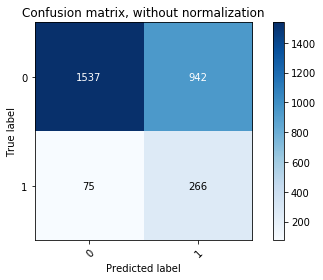

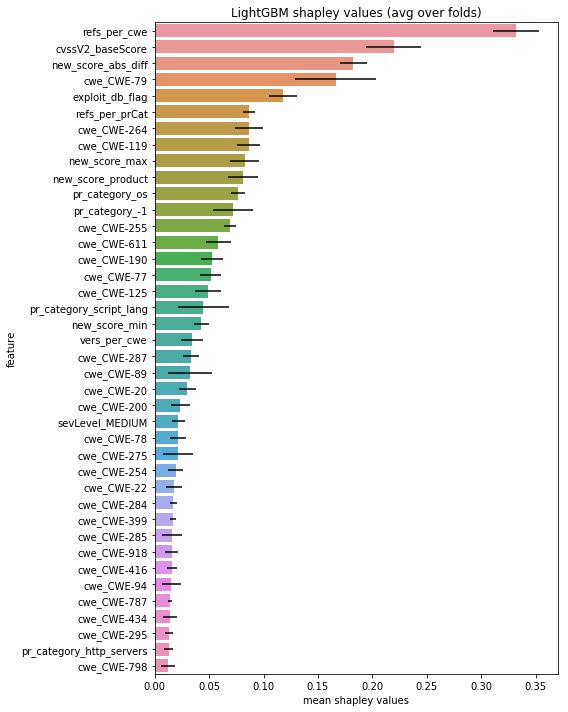

Wall time: 9.49 s


In [451]:
%%time

feat_importance, models, scores = kfold_lightgbm(X_train, y_train, X_test, y_test, num_folds=5, stratified=True, debug=debug)

A very useful feature of LightGBM model - it allows to add more weights to minority class, thus making the model more sensitive to minority classes. Moreover, depending on our goals we can further increase the `scale_pos_weight` value to heavier penalize incorrectly classified minority class labels. In this case, we increased `scale_pos_weight` 2 times from 8 (actual class proportion) to 16.

In this case, model can predict 75% of all CVE entries editable for a long period of time.

For a field of cybersecurity, it may be especially important to avoid false negatives, i.e. not to miss alarms on vulnerabilities and exposures in new versions of systems rather than avoiding false positives. 

# Experimental results: are we able to predict long-editable CVE entries?

Let's move to the most interesting part of our analysis: the interpretation of obtained results from our predictive model using SHAP values. 

### SHAP importance

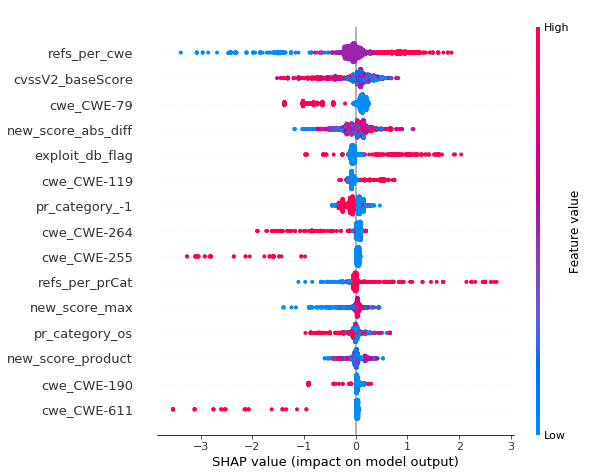

In [452]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X_test)

# summarize the effects of top features
shap.summary_plot(shap_values, X_test, max_display=15)

The SHAP values for LightGBM explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model. This plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

We can see above that the primary risk factor for CVE issues being reported for a long period of time according to the model is the nummber of references per CWE. 

The next most powerful indicator of long-lasting CVE reports is `cvssV2_baseScore`. High base score leads to faster solving of CVE problem.

References to exploit-db website while combining with other factors used in our model usually mean that the CVEs would be long-editable.

Interestingly, the additional feature we added -- `new_score_abs_diff` which is the absolute difference of `cvssV2_impactScore` and `cvssV2_exploitabilityScore` also turned out to be an important factors in predicting the length of CVE information modification on NVD website. The lower `new_score_abs_diff` the faster CVEs issues are closing. However,  the big difference in `cvssV2_impactScore` and `cvssV2_exploitabilityScore` does not play significant role in CVE modification period predicting. 

The origin of CVE being CWE-79 which is as we remember the memory-boundary problem is the third important factor in our model. On average, all memory-boundary problem related CVEs reports are with short editable period. 

### Dependence contribution plot

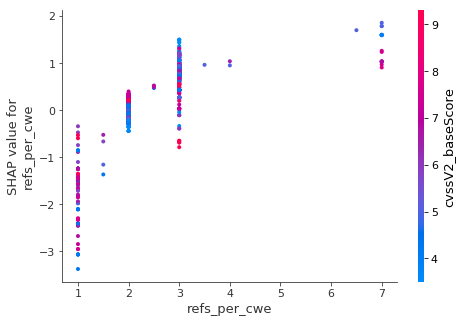

In [453]:
# make plot.
shap.dependence_plot('refs_per_cwe', shap_values, X_test)

If one doesn't supply an argument for `interaction_index` parameter of the `dependence_plot` function, Shapley uses some logic to pick one that may be interesting. Here, it picked up `cvssV2_baseScore`. 

Interestingly to notice that if the `refs_per_cwe` is equal to 2 then the lower `cvssV2_baseScore` will in general decrease the chance of CVE being reported for a long time. But, the situation completely changes if there are more than 3 references per related CWE.  

One can check other combination of parameters of their interest using the SHAP dependency contribution plot technique.

# Limitations of experiment and future work

In the end, it is needed to point out again the limitations of our built predictive model and give the ideas for future work:

<u>Limitations</u>:
- it was presumed that the fields of JSON file were filled on the `publishedDate`, however, it is not true: the content of NVD report was changing all the time during the CVE modification period. 
- we roughly defined the product categories. Half of the reported vulnerable systems were left with the undefined product category. Use of more precise category assignment could further improve the model quality.
- CVE description fields were not used in this analysis. Although, it can potentially be useful for our or some other tasks.

**Despite the drawbacks mentioned, our model is still a good approximation of the situation when we want to predict the re-occurence of CVE in some system using the current state CVE data as a proxy. With the class disbalance of 1:8, our model was able to correctly define 75% of minority class samples, ie CVE entries with modification period longer than 4 months.** 

<u>Future work</u>:
- better tune LightGBM model parameters using Bayesian optimization (or use the GridSearch technique for these purposes)
- use ensembles of different models. From my experience, the majority vote on tree-based method predictions together with KNN and neural network models predictions usually gives better results than separate models do
- obtain previous NVD reports and re-run our model to see how it predicts the new entry on some vulnerabilities and exposures using the statistics from previous entries.
- get data from external sources on all system version releases for a system to see which one was not vulnerable. Then, the good task would be to predict the probability of the next system version release to be vulnerable. Or another option could be to predict the CVE severity using the same modeling technique as was done above.


Finally, I would like to mention some other research ideas which came to my mind while working on this notebook:

- it would be interesting to look at the data from the biological data modeling perspective. What if we consider the chain of system versions (or source code) as a gene, for example, DNA. And the potential thread as a disease or mutation in genes. Then, it is possible to construct embeddings of threads or systems (or source codes) to find similar embeddings. The visualization of them will allow finding similar vectors of threads or systems (unsupervised approach). The trained embeddings can further be used for a range of predictive tasks (supervised approach). So, something similar to the experiment described in this [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6329279/) on disease prediction using gene expression information can potentially be done using cybersecurity-related data. 
- consider the chains of system versions or source code as sentences. Then all the techniques from NLP domain could be applicable here to solve a variety of problems as, for example it was done in this [paper](https://arxiv.org/pdf/1708.02368.pdf).

                                   Thank you for checking my notebook 🙂